In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

In [3]:
# Preprocess - Round to nearest 5 minutes
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')

# Filter out rows where mg/dl is > 400 or missing values
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])

# Drop duplicates and sort
cgm_data = cgm_data.drop_duplicates(subset='date').reset_index(drop=True)
cgm_data = cgm_data.sort_values(by='date').reset_index(drop=True)

In [4]:
# Generate AR Features (using past 12 readings as input)
num_lags = 12 # Using the past 12 values
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

cgm_data = cgm_data.dropna().reset_index(drop=True)

In [5]:
# Split into train/test (80% train, 20% test by time order)
train_size = int(len(cgm_data) * 0.8)
train_data = cgm_data[:train_size]
test_data = cgm_data[train_size:]

In [6]:
# Define function to train and evaluate for different time steps
def train_ar_model(data, target_step):
    # Prepare inputs (X) and target (y)
    X = data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y = data['mg/dl'].shift(-target_step).dropna().values
    X = X[:len(y)]  # Align lengths

    # Split into train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate performance metric (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Use np.sqrt on MSE

    # Display the coefficients
    coefficients = model.coef_
    intercept = model.intercept_

    print("Linear Regression Coefficients (lags):")
    for i, coef in enumerate(coefficients, start=1):
      print(f"Lag {i}: {coef:.4f}")
    print(f"Intercept: {intercept:.4f}")

    return model, rmse

In [7]:
# Train models for different time step targets and evaluate
time_steps = [3, 6, 9, 12]  # Corresponding to 15, 30, 45, 60 minutes
results = {}

for step in time_steps:
    model, rmse = train_ar_model(cgm_data, step)
    results[f'{step*5} min ahead'] = {'Model': model, 'RMSE': rmse}
    print(f"Time step {step} (predicting {step*5} minutes ahead) - RMSE: {rmse:.4f}")

# Results dictionary now contains trained models and RMSE for each time target

Linear Regression Coefficients (lags):
Lag 1: 1.5483
Lag 2: -0.2848
Lag 3: -0.1474
Lag 4: -0.0769
Lag 5: -0.0193
Lag 6: -0.0248
Lag 7: -0.0243
Lag 8: -0.0207
Lag 9: -0.0121
Lag 10: -0.0036
Lag 11: -0.0010
Lag 12: -0.0100
Intercept: 13.6443
Time step 3 (predicting 15 minutes ahead) - RMSE: 18.8309
Linear Regression Coefficients (lags):
Lag 1: 1.6500
Lag 2: -0.3433
Lag 3: -0.1875
Lag 4: -0.1063
Lag 5: -0.0357
Lag 6: -0.0331
Lag 7: -0.0313
Lag 8: -0.0271
Lag 9: -0.0151
Lag 10: -0.0043
Lag 11: 0.0006
Lag 12: -0.0158
Intercept: 26.5293
Time step 6 (predicting 30 minutes ahead) - RMSE: 28.8924
Linear Regression Coefficients (lags):
Lag 1: 1.6425
Lag 2: -0.3706
Lag 3: -0.2004
Lag 4: -0.1151
Lag 5: -0.0428
Lag 6: -0.0371
Lag 7: -0.0331
Lag 8: -0.0260
Lag 9: -0.0207
Lag 10: -0.0072
Lag 11: -0.0015
Lag 12: -0.0121
Intercept: 39.9206
Time step 9 (predicting 45 minutes ahead) - RMSE: 36.9419
Linear Regression Coefficients (lags):
Lag 1: 1.5697
Lag 2: -0.3695
Lag 3: -0.1997
Lag 4: -0.1142
Lag 5: -0

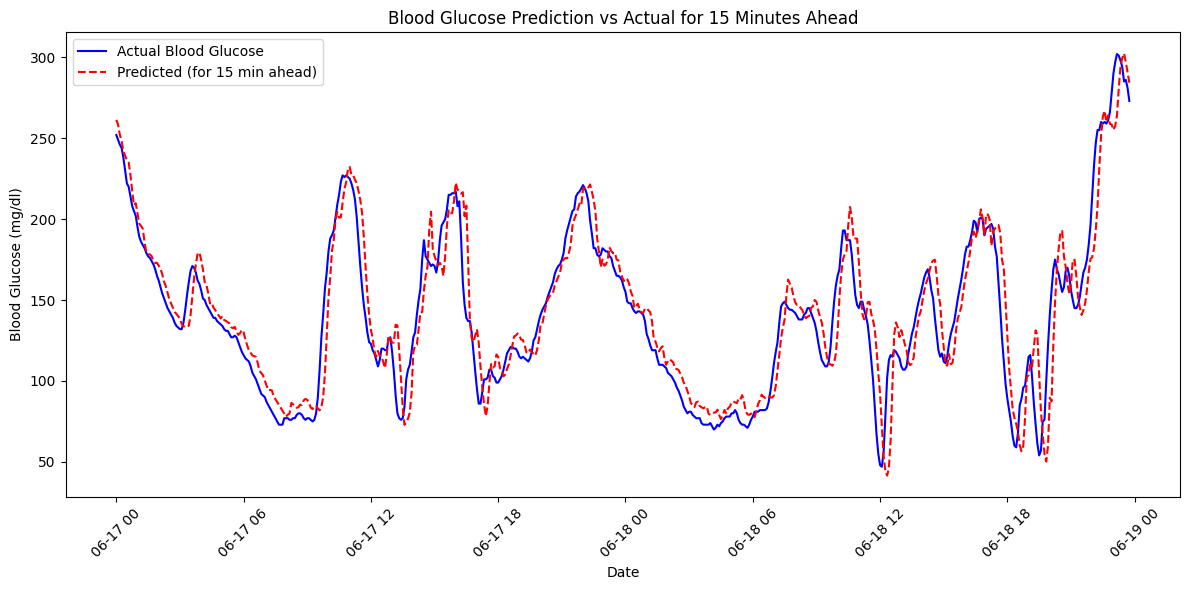

In [8]:
import matplotlib.pyplot as plt

# Function to make predictions for a specific week and plot them
def plot_predictions_for_week(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths

    # Make predictions
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates
start_date = '2021-06-17'
end_date = '2021-06-19'
plot_predictions_for_week(cgm_data[train_size:], results['15 min ahead']['Model'], 3, start_date, end_date)


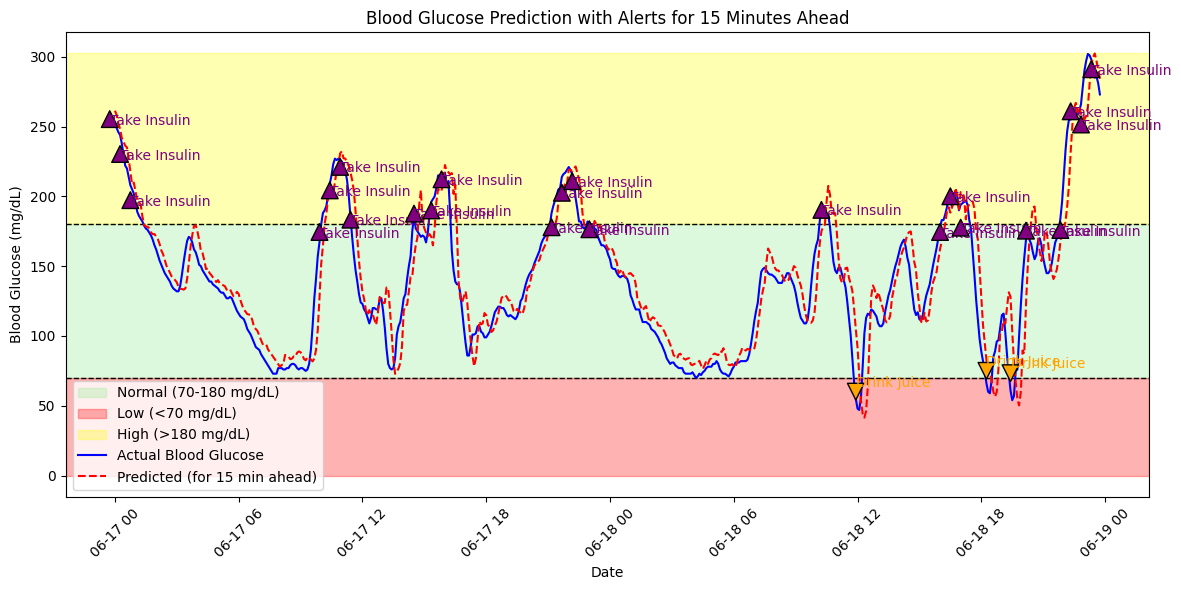

In [9]:
import matplotlib.pyplot as plt
from datetime import timedelta

# Function to add regions and adjusted markers to the plot
def plot_predictions_with_early_annotations(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Highlight regions
    plt.axhspan(70, 180, color='lightgreen', alpha=0.3, label='Normal (70-180 mg/dL)')
    plt.axhspan(0, 70, color='red', alpha=0.3, label='Low (<70 mg/dL)')
    plt.axhspan(180, max(y_actual.max(), y_pred.max()), color='yellow', alpha=0.3, label='High (>180 mg/dL)')

    # Add dotted lines for thresholds
    plt.axhline(70, color='black', linestyle='--', linewidth=1)
    plt.axhline(180, color='black', linestyle='--', linewidth=1)

    # Plot actual vs. predicted values
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')

    # Add markers for recommendations, adjusted for early action
    last_marker_time = None
    for i, (pred, date) in enumerate(zip(y_pred, dates)):
        action_time = date - timedelta(minutes=15)  # Adjust marker time by 15 minutes earlier
        if last_marker_time and (action_time - last_marker_time).seconds < 30 * 60:
            continue  # Skip if less than 30 minutes since last marker

        if pred < 70:
            plt.annotate('Drink Juice', xy=(action_time, pred), xytext=(action_time, pred + 10),
                         arrowprops=dict(facecolor='orange', shrink=0.05), color='orange')
            last_marker_time = action_time
        elif pred > 180:
            plt.annotate('Take Insulin', xy=(action_time, pred), xytext=(action_time, pred - 10),
                         arrowprops=dict(facecolor='purple', shrink=0.05), color='purple')
            last_marker_time = action_time

    # Finalize plot
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dL)')
    plt.title(f'Blood Glucose Prediction with Alerts for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates
start_date = '2021-06-17'
end_date = '2021-06-19'
plot_predictions_with_early_annotations(cgm_data[train_size:], results['15 min ahead']['Model'], 3, start_date, end_date)


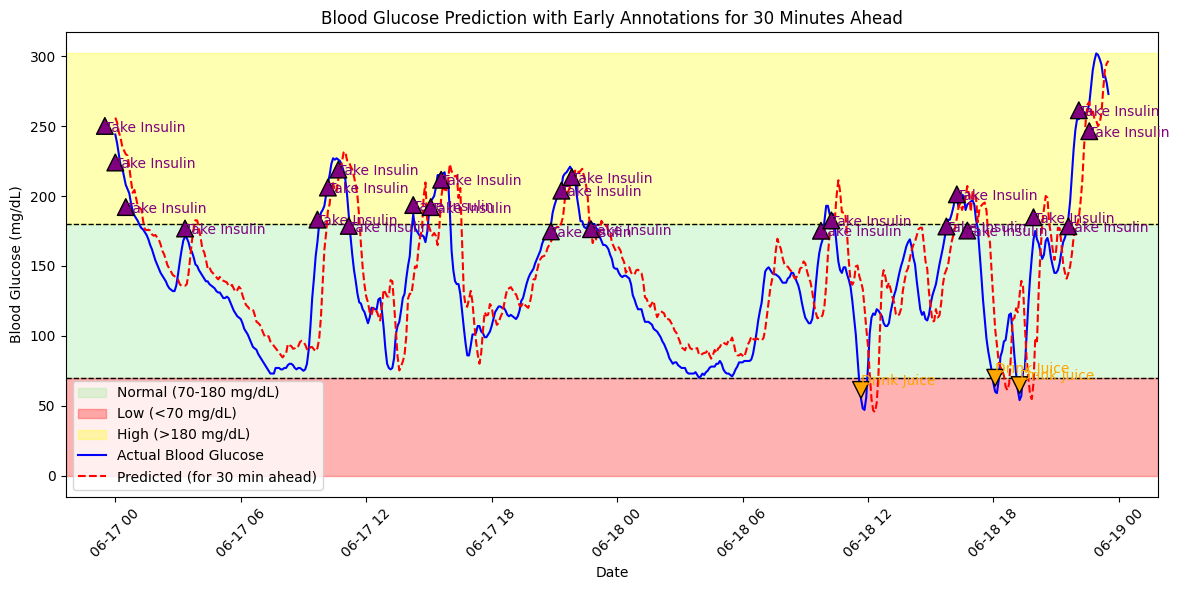

In [10]:
import matplotlib.pyplot as plt
from datetime import timedelta

# Function to add regions and adjusted markers to the plot
def plot_predictions_with_early_annotations_30min(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Highlight regions
    plt.axhspan(70, 180, color='lightgreen', alpha=0.3, label='Normal (70-180 mg/dL)')
    plt.axhspan(0, 70, color='red', alpha=0.3, label='Low (<70 mg/dL)')
    plt.axhspan(180, max(y_actual.max(), y_pred.max()), color='yellow', alpha=0.3, label='High (>180 mg/dL)')

    # Add dotted lines for thresholds
    plt.axhline(70, color='black', linestyle='--', linewidth=1)
    plt.axhline(180, color='black', linestyle='--', linewidth=1)

    # Plot actual vs. predicted values
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')

    # Add markers for recommendations, adjusted for early action
    last_marker_time = None
    for i, (pred, date) in enumerate(zip(y_pred, dates)):
        action_time = date - timedelta(minutes=30)  # Adjust marker time by 30 minutes earlier
        if last_marker_time and (action_time - last_marker_time).seconds < 30 * 60:
            continue  # Skip if less than 30 minutes since last marker

        if pred < 70:
            plt.annotate('Drink Juice', xy=(action_time, pred), xytext=(action_time, pred + 10),
                         arrowprops=dict(facecolor='orange', shrink=0.05), color='orange')
            last_marker_time = action_time
        elif pred > 180:
            plt.annotate('Take Insulin', xy=(action_time, pred), xytext=(action_time, pred - 10),
                         arrowprops=dict(facecolor='purple', shrink=0.05), color='purple')
            last_marker_time = action_time

    # Finalize plot
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dL)')
    plt.title(f'Blood Glucose Prediction with Early Annotations for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates
start_date = '2021-06-17'
end_date = '2021-06-19'
plot_predictions_with_early_annotations_30min(cgm_data[train_size:], results['30 min ahead']['Model'], 6, start_date, end_date)


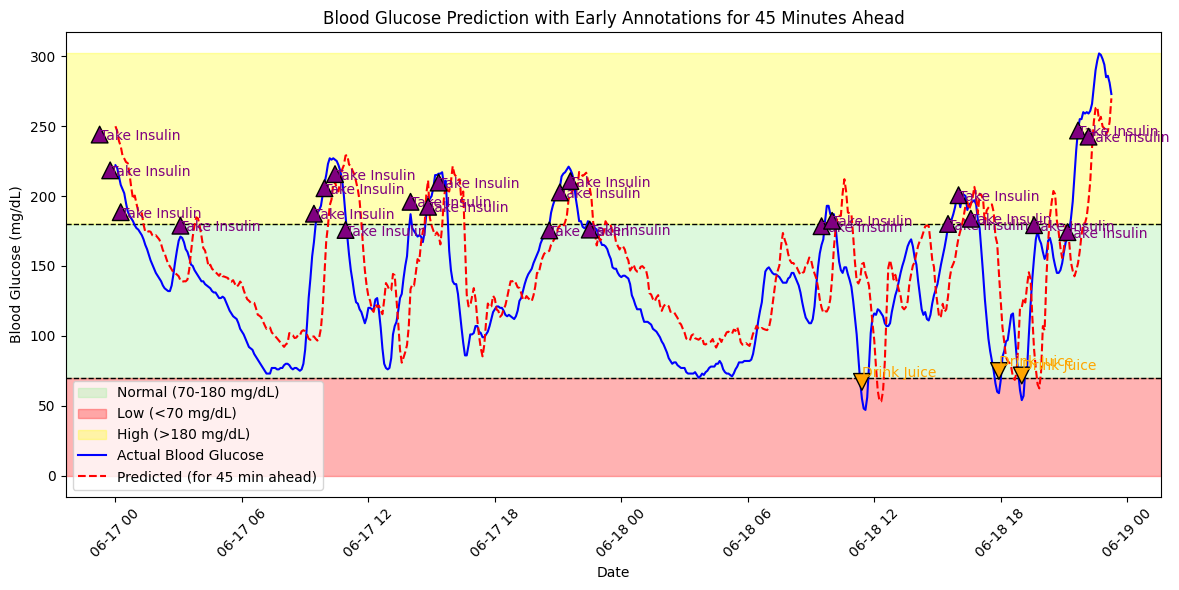

In [11]:
import matplotlib.pyplot as plt
from datetime import timedelta

# Function to add regions and adjusted markers to the plot
def plot_predictions_with_early_annotations_45min(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Highlight regions
    plt.axhspan(70, 180, color='lightgreen', alpha=0.3, label='Normal (70-180 mg/dL)')
    plt.axhspan(0, 70, color='red', alpha=0.3, label='Low (<70 mg/dL)')
    plt.axhspan(180, max(y_actual.max(), y_pred.max()), color='yellow', alpha=0.3, label='High (>180 mg/dL)')

    # Add dotted lines for thresholds
    plt.axhline(70, color='black', linestyle='--', linewidth=1)
    plt.axhline(180, color='black', linestyle='--', linewidth=1)

    # Plot actual vs. predicted values
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')

    # Add markers for recommendations, adjusted for early action
    last_marker_time = None
    for i, (pred, date) in enumerate(zip(y_pred, dates)):
        action_time = date - timedelta(minutes=45)  # Adjust marker time by 45 minutes earlier
        if last_marker_time and (action_time - last_marker_time).seconds < 30 * 60:
            continue  # Skip if less than 30 minutes since last marker

        if pred < 70:
            plt.annotate('Drink Juice', xy=(action_time, pred), xytext=(action_time, pred + 10),
                         arrowprops=dict(facecolor='orange', shrink=0.05), color='orange')
            last_marker_time = action_time
        elif pred > 180:
            plt.annotate('Take Insulin', xy=(action_time, pred), xytext=(action_time, pred - 10),
                         arrowprops=dict(facecolor='purple', shrink=0.05), color='purple')
            last_marker_time = action_time

    # Finalize plot
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dL)')
    plt.title(f'Blood Glucose Prediction with Early Annotations for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates
start_date = '2021-06-17'
end_date = '2021-06-19'
plot_predictions_with_early_annotations_45min(cgm_data[train_size:], results['45 min ahead']['Model'], 9, start_date, end_date)


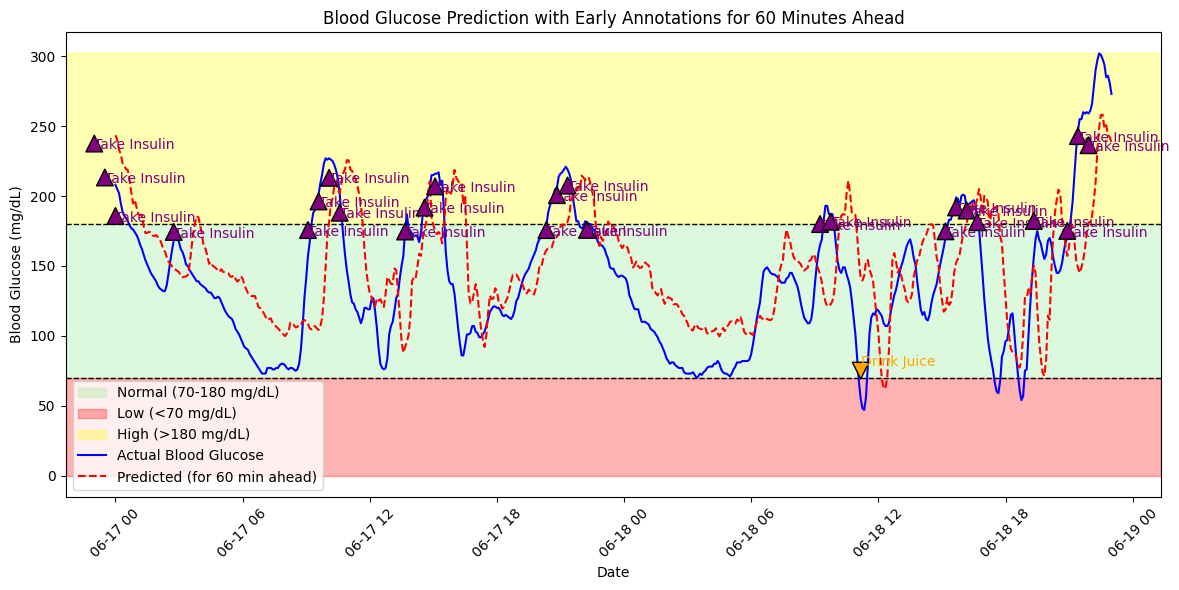

In [12]:
import matplotlib.pyplot as plt
from datetime import timedelta

# Function to add regions and adjusted markers to the plot
def plot_predictions_with_early_annotations_60min(data, model, target_step, start_date, end_date):
    # Filter the test data to the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Prepare inputs for prediction
    X_week = week_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
    y_actual = week_data['mg/dl'].shift(-target_step).dropna().values
    X_week = X_week[:len(y_actual)]  # Align lengths
    y_pred = model.predict(X_week)

    # Adjust actual and date values to align with predictions
    dates = week_data['date'][:len(y_actual)]

    # Plotting
    plt.figure(figsize=(12, 6))

    # Highlight regions
    plt.axhspan(70, 180, color='lightgreen', alpha=0.3, label='Normal (70-180 mg/dL)')
    plt.axhspan(0, 70, color='red', alpha=0.3, label='Low (<70 mg/dL)')
    plt.axhspan(180, max(y_actual.max(), y_pred.max()), color='yellow', alpha=0.3, label='High (>180 mg/dL)')

    # Add dotted lines for thresholds
    plt.axhline(70, color='black', linestyle='--', linewidth=1)
    plt.axhline(180, color='black', linestyle='--', linewidth=1)

    # Plot actual vs. predicted values
    plt.plot(dates, y_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(dates, y_pred, label=f'Predicted (for {target_step*5} min ahead)', color='red', linestyle='--')

    # Add markers for recommendations, adjusted for early action
    last_marker_time = None
    for i, (pred, date) in enumerate(zip(y_pred, dates)):
        action_time = date - timedelta(minutes=60)  # Adjust marker time by 60 minutes earlier
        if last_marker_time and (action_time - last_marker_time).seconds < 30 * 60:
            continue  # Skip if less than 30 minutes since last marker

        if pred < 70:
            plt.annotate('Drink Juice', xy=(action_time, pred), xytext=(action_time, pred + 10),
                         arrowprops=dict(facecolor='orange', shrink=0.05), color='orange')
            last_marker_time = action_time
        elif pred > 180:
            plt.annotate('Take Insulin', xy=(action_time, pred), xytext=(action_time, pred - 10),
                         arrowprops=dict(facecolor='purple', shrink=0.05), color='purple')
            last_marker_time = action_time

    # Finalize plot
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dL)')
    plt.title(f'Blood Glucose Prediction with Early Annotations for {target_step*5} Minutes Ahead')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Replace with desired dates
start_date = '2021-06-17'
end_date = '2021-06-19'
plot_predictions_with_early_annotations_60min(cgm_data[train_size:], results['60 min ahead']['Model'], 12, start_date, end_date)
